In [19]:

%matplotlib notebook

import numpy as np
from scipy.stats import multivariate_normal
from multitools import set_cam_poses, set_vir_poses
from multitools import get_transmats, get_rotmats
from multitools import get_b_pose_from_a_pose, get_angles
from multitools import visualize_all_cigars



from scipy import stats
import time
import math
import matplotlib.pyplot as plt

def get_euclidian_d(w_pose, prediction):
    dx = abs(w_pose[0]-prediction[0])
    dy = abs(w_pose[1]-prediction[1])
    dz = abs(w_pose[2]-prediction[2])
    
    print("dx = {:.3f} | dy = {:.3f} | dz = {:.3f} in cm".format(100*dx, 100*dy, 100*dz))
    
    d = math.sqrt(dx*dx+dy*dy+dz*dz)
    return d

def get_3_joint_rv(x, y, z, rv):
    
    p1 = rv[0].pdf([x, y, z])
    p2 = rv[1].pdf([x, y, z])
    p3 = rv[2].pdf([x, y, z])
    
    p = np.cbrt(p1*p2*p3)
    
#     p = p1*p2*p3
        
    return p

def predict_pose(nb_pts, rv, mean, w_pose):
    
    x = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + np.mean(mean[0,:])
    y = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + np.mean(mean[1,:])
    z = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + np.mean(mean[2,:])

    # Getting joint probabilities
    start = time.time()
    p = np.zeros((nb_pts,nb_pts, nb_pts))
    for idx_x in range (nb_pts): # x, y, z
        for idx_y in range (nb_pts): # x, y, z
            for idx_z in range (nb_pts): # x, y, z   
                p[idx_x, idx_y, idx_z] = get_3_joint_rv(x[idx_x], y[idx_y], z[idx_z], rv)

    stop = time.time()
    elapsed = stop - start
    print("Joint probabilities obtained after: " + str(int(elapsed)) + " seconds.")


    threshold = 0
    while True:
        threshold += 0.05
        idx = p > threshold
        nzc = np.count_nonzero(idx)
#         print("th={:.3f} --> ## ={:.3f}".format(threshold, nzc))
        if nzc < 100:
            print("Final Threshold : {:.3f}".format(threshold))
            break

    # Indices of Max Probability
    imp = np.unravel_index(np.argmax(p, axis=None), p.shape) 
    prediction = [x[imp[0]], y[imp[1]], z[imp[2]]]
    
    print("Prediction: ({:.3f}, {:.3f}, {:.3f})".format(x[imp[0]], y[imp[1]], z[imp[2]]))
    d = get_euclidian_d(w_pose, prediction)
    print("Error in cm : {:.3f}".format(100*d))
    
    xx, yy, zz = np.meshgrid(x, y, z)
    
    return xx, yy, zz, p, idx, d


def py_predict_pose(nb_pts, rv, mean, w_pose):
    
    x = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + np.mean(mean[0,:])
    y = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + np.mean(mean[1,:])
    z = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + np.mean(mean[2,:])

    xx, yy, zz = np.meshgrid(x, y, z)
    xyz = np.zeros((nb_pts,nb_pts, nb_pts,3))
    xyz[:,:,:,0] = xx
    xyz[:,:,:,1] = yy
    xyz[:,:,:,2] = zz
    
    # Getting joint probabilities
    start = time.time()
    
    p1 = rv[0].pdf(xyz)
    p2 = rv[1].pdf(xyz)
    p3 = rv[2].pdf(xyz)
    
    print(np.amax(p1))
    print(np.amax(p2))
    print(np.amax(p3))
    
    p = np.cbrt(np.multiply(p1,np.multiply(p2,p3)))
#     p = np.cbrt(p1*p2*p3)

    print(p1[0:3,0:3,0:3])
    print(p2[0:3,0:3,0:3])
    print(p3[0:3,0:3,0:3])
    print(p[0:3,0:3,0:3])

    stop = time.time()
    elapsed = stop - start
    print("Joint probabilities obtained after: " + str(int(elapsed)) + " seconds.")


    threshold = 0
    while True:
        threshold += 0.01
        idx = p > threshold
        nzc = np.count_nonzero(idx)
#         print("th={:.3f} --> ## ={:.3f}".format(threshold, nzc))
        if nzc < 100:
            print("Final Threshold : {:.3f}".format(threshold))
            break

    # Indices of Max Probability
    imp = np.unravel_index(np.argmax(p, axis=None), p.shape) 
    prediction = [x[imp[0]], y[imp[1]], z[imp[2]]]
    
    print("Prediction: ({:.3f}, {:.3f}, {:.3f})".format(x[imp[0]], y[imp[1]], z[imp[2]]))
    d = get_euclidian_d(w_pose, prediction)
    print("\033[1m" + "Error in cm : {:.3f}\n\n".format(100*d)+ "\033[0m")
#     "\033[1m" + a_string + "\033[0m"
    
    return xx, yy, zz, p, idx, d

def visualize_intersection(xx, yy, zz, p, idx, w_pose):
        
    
    # Creating figure
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection="3d")
    

    # Creating plot
    ax.scatter3D(yy[idx], -xx[idx], zz[idx], c=p[idx], cmap='viridis', vmin=0, vmax=10, marker='.')
    ax.scatter3D(w_pose[1], -w_pose[0],  w_pose[2], cmap='Reds', vmin=0, vmax=10, marker='p')

    ax.set_xlabel('y')
    ax.set_ylabel('-x')
    ax.set_zlabel('z')    
    
    max_x = 1.5
    max_y = 1.5
    max_z = 1.5
    min_x = -1.5
    min_y = -1.5
    min_z = -1.5
    
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    
#     ax.view_init(0,180) # Top View
    
    plt.show()    
    
def prepare_ground(w_pose):
        
    # Get camera poses
    r_cam_poses = set_cam_poses()
    
    # Get Rotation Matrices: real-cam to world 
    r2w = get_rotmats(r_cam_poses)
    
    # Get Translation Matrices: real-cam to world
    r_trl = get_transmats(r_cam_poses)
        
    # Get poses and angles of connecting ray vs Z axis in real-cam space
    r_obj_poses = np.zeros((3,3))       
    r_obj_angles = np.zeros((2,3))    
    for k in range(3):
        r_obj_poses[:,k] = get_b_pose_from_a_pose(r2w[:,:,k], r_trl[:,:,k], w_pose)
        r_obj_angles[0:2, k] = get_angles(r_obj_poses[:,k])
            
    # Estimate virtual camera poses (in real camera space)
    v_poses = set_vir_poses(r_obj_angles)
        
    # Get Rotation Matrices: virtual-cam to real-cam 
    v2r = get_rotmats(v_poses)
        
    # Get poses in virtual-cam space
    v_obj_poses = np.zeros((3,3))  
    v_obj_angles = np.zeros((2,3))    
    for k in range(3):
        v_obj_poses[:,k] = get_b_pose_from_a_pose(v2r[:,:,k], np.identity(4), r_obj_poses[:,k])
        v_obj_angles[0:2, k] = get_angles(v_obj_poses[:,k])
        # @TODO: The angles here should be exactly ZERO !!! WTF?!?!?
#         print(np.round(v_poses[:,k],3))        
#         print(v_angles[0:2, k])
    print("vir_z_123 = ({:.3f}, {:.3f}, {:.3f})".format(np.round(v_obj_poses[2,0],3), np.round(v_obj_poses[2,1],3), np.round(v_obj_poses[2,2],3)))
    
    return r_trl, r2w, v2r, r_obj_poses, v_obj_poses

''' Create Multivariate Gaussian Distributions'''
def create_mgd(μ, Σ, r_trl, r2w, v2r, v_obj_poses):   
   
    r_μ = np.zeros((3,3))
    r_Σ = np.zeros((3,3,3))
    w_μ = np.zeros((3,3))
    w_Σ = np.zeros((3,3,3))
    new_μ = np.zeros((4,3)) # including a '1' at the end
    for k in range(3):
        
        # @TODO: only for testing purposes
#         μ[2] = v_obj_poses[2,k]
                                      
        # Rotating Means from virtual-cam space to real-cam space  
        r_μ[:,k] = v2r[:,:,k] @ μ
                 
        # Rotating Means from real-cam space to world space 
        w_μ[:,k] = r2w[:,:,k] @ r_μ[:,k]
    
        # Translating Means from Camera (Real=Virtual) space to World space 
        new_μ[:,k] = r_trl[:,:, k] @ [w_μ[0,k], w_μ[1,k], w_μ[2,k],1]                     
                 
        # Rotating Covariance Matrix from virtual-cam space to real-cam space  
        r_Σ[:,:,k] = v2r[:,:,k] @ Σ @ v2r[:,:,k].T  
                 
        # Rotating Covariance Matrix from real-cam space to world space  
        w_Σ[:,:,k] = r2w[:,:,k] @ r_Σ[:,:,k] @ r2w[:,:,k].T 
    
    rv_1 = multivariate_normal(new_μ[0:3,0], w_Σ[:,:,0])
    rv_2 = multivariate_normal(new_μ[0:3,1], w_Σ[:,:,1])
    rv_3 = multivariate_normal(new_μ[0:3,2], w_Σ[:,:,2])
    
    return new_μ, [rv_1, rv_2, rv_3]

def get_w_bases(nb_samples):
    
    w_x = np.linspace(-0.5, 0, num=nb_samples) 
    w_y = np.linspace(0.0, 1, num=nb_samples)
    w_z = np.linspace(0.7, 1.2, num=nb_samples)
    
    return w_x, w_y, w_z

In [20]:

if __name__ == '__main__':
    
    # Number of points, per axis, to evaluate
    nb_pts = 100
    
    nb_s = 1
    w_x, w_y, w_z = get_w_bases(nb_s)
        
    e_d = np.zeros((nb_s, nb_s, nb_s)) # error in euler distance in [cm]
    for i in range(nb_s):
        for j in range(nb_s):
            for k in range(nb_s):
                
                # Object's pose in world space
                w_pose = np.array([w_x[i], w_y[j], w_z[k]])  
                
                w_pose = [-0.35, 0.1, 0.95]
                
                print("For w_pose = ({:.3f}, {:.3f}, {:.3f})".format(w_pose[0], w_pose[1], w_pose[2]))
                

                # Original covariance matrix in virtual camera space
                μ = np.array([0,0,-0.6])
                Σ = np.array([[0.0001,0,0],[0,0.0001,0],[0,0,0.2]])    

                # Go to virtual space and get data (matrices) in the process
                r_trl, r2w, v2r, r_obj_poses, v_obj_poses = prepare_ground(w_pose)

                # Create gaussians in virtual space and transform them into world space
                new_μ, rv = create_mgd(μ, Σ, r_trl, r2w, v2r, v_obj_poses)

                # Do predictions
                x, y, z, p, idx, e_d[i,j,k] = predict_pose(nb_pts, rv, new_μ, w_pose)

For w_pose = (-0.350, 0.100, 0.950)
vir_z_123 = (-0.993, -1.002, -1.020)
Joint probabilities obtained after: 45 seconds.
Final Threshold : 0.050
Prediction: (-0.369, 0.099, 0.945)
dx = 1.892 | dy = 0.111 | dz = 0.520 in cm
Error in cm : 1.965


In [21]:
100*np.mean(e_d)

1.9652618931345627

<IPython.core.display.Javascript object>


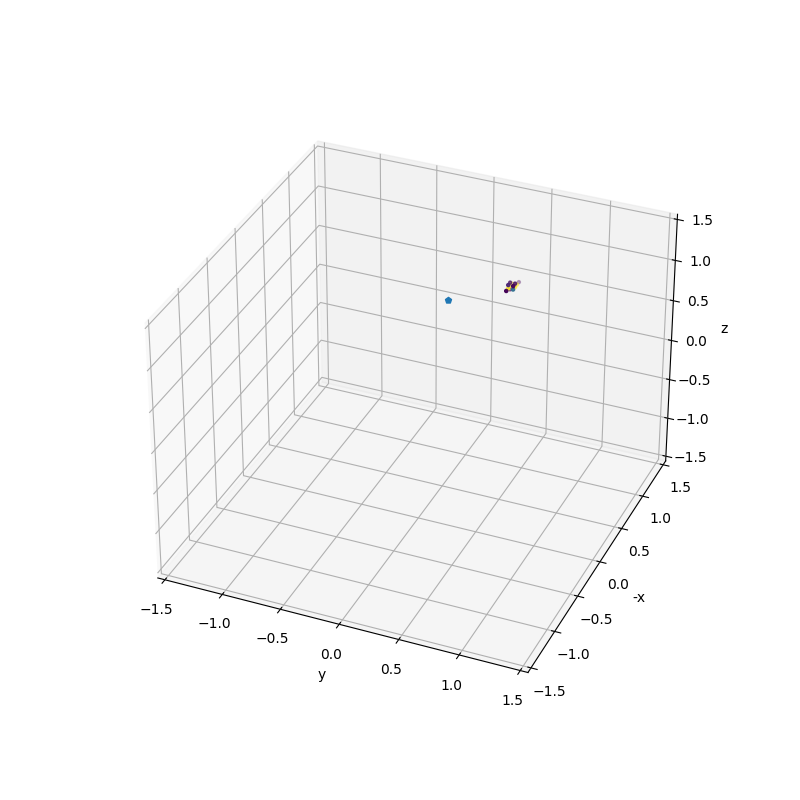

In [23]:
%matplotlib notebook
visualize_intersection(x, y, z, p, idx, w_pose)

In [5]:
# %matplotlib notebook

# threshold = 1
# visualize_all_cigars(nb_pts, rv, new_μ, threshold)